In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
import math
import scipy.linalg as la
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance

Using TensorFlow backend.


In [3]:
iris = sns.load_dataset('iris')

# matrix data
X = np.array(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
specs = np.array(iris['species'])

Potential improvement: Write a recursive binary search algorithm rather than iterative bc it will be faster. We could potentially use a C++ binary search function

In [4]:
def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    D = distance.squareform(distance.pdist(X, 'sqeuclidean'))
    return D

def p_cond(d_matrix, sigmas):
    """Convert a distances matrix to a matrix of conditional probabilities."""
    
    sig_2 = np.square(sigmas.reshape((-1, 1)))
    P_cond = np.exp((d_matrix / (2 * sig_2)) - np.max((d_matrix / (2 * sig_2)), axis=1).reshape([-1, 1]))

    # set p_i|i = 0
    np.fill_diagonal(P_cond, 0.)

    P_cond = (P_cond +  1e-10)/ (P_cond + 1e-10).sum(axis=1).reshape([-1, 1])
    
    return P_cond


def binary_search(eval_fn, target, tol=1e-10, max_iter=10000, 
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.
    
    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        mid = (lower + upper) / 2.
        val = eval_fn(mid)
        if val > target:
            upper = mid
        else:
            lower = mid
        if np.abs(val - target) <= tol:
            break
    return mid

def perp(d_matrix, sigmas):
    """calculate perplexity from distance matrix, sigmas, and conditional probability matrix."""
    P = p_cond(d_matrix, sigmas)
    entropy = -np.sum(P * np.log2(P), axis = 1)
    perplexity = 2 ** entropy
    
    return perplexity


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P



def find_optimal_sigmas(d_matrix, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = [] 
    # For each row of the matrix (each point in our dataset)
    for i in range(d_matrix.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perp(d_matrix[i:i+1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)

def p_ij(X, target_perplexity = 30):
    """Calculate joint probabilities in the high dimensional space given data matrix X 
    and a target perplexity to find optimal sigmas (pg. 2584).
    """

    d_matrix = -squared_euc_dist(X)
    
    # optimal sigma for each row of distance matrix
    sigmas = find_optimal_sigmas(d_matrix, target_perplexity)
    
    # conditional p matrix from optimal sigmas
    p_conditional = p_cond(d_matrix, sigmas)
    
    # convert conditional P to joint P matrix (pg. 2584) 
    n = p_conditional.shape[0]
    p_joint = (p_conditional + p_conditional.T) / (2. * n)
    
    return p_joint

def q_ij(Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""
    
    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)
    
    # q_i|i = 0
    np.fill_diagonal(Q, 0.)
    
    return Q



def grad_C(P, Q, Y):
    """Calculate gradient of cost function (KL) with respect to lower dimensional map points Y (pg. 2586)"""

    pq_diff = (P-Q)[:, :, np.newaxis]

    y_diff = Y[:, np.newaxis, :] - Y[np.newaxis, :, :]
    
    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))[:, :, np.newaxis]

    grad = 4. * (pq_diff * y_diff * y_dist).sum(axis = 1)
    
    return grad


def tsne_opt(X, num_iters = 1000, perplexity = 30, alpha = 10, momentum = 0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    
    Inputs: 
        X: data matrix 
        num_iters: number of iterations 
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm 
    """

    # Initialize Y 
    Y = (np.random.RandomState(1)).normal(0., 0.0001, [X.shape[0], 2])
    
    P = p_ij(X, perplexity)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):

        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - (alpha * grad)) +  (momentum * (Y_tmin1 - Y_tmin2))
  
        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y


Say momentum GD is one of the ways we sped up the algorithm (tip from paper)

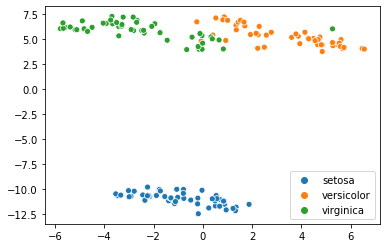

In [12]:
yout = tsne_opt(X)
sns.scatterplot(yout[:,0], yout[:,1], hue = specs)

### Profiling and Optimizing 

In [7]:
import cython
import timeit
import math
import time
import pstats

In [8]:
%load_ext cython

In [14]:
%%time 

tsne_opt(X)

CPU times: user 2.67 s, sys: 12 ms, total: 2.68 s
Wall time: 2.64 s


array([[-1.31957355e+00, -1.10512004e+01],
       [ 6.95844833e-01, -1.10742098e+01],
       [ 5.08784056e-01, -1.17259164e+01],
       [ 8.79980641e-01, -1.15495239e+01],
       [-1.38658057e+00, -1.12104949e+01],
       [-2.78754966e+00, -1.02514361e+01],
       [ 2.40459467e-01, -1.19301422e+01],
       [-7.72085208e-01, -1.09699325e+01],
       [ 1.34982292e+00, -1.18446967e+01],
       [ 4.30103052e-01, -1.10120727e+01],
       [-2.44075636e+00, -1.06276818e+01],
       [-2.03468100e-01, -1.09430809e+01],
       [ 8.61691602e-01, -1.12485304e+01],
       [ 1.32152034e+00, -1.22034604e+01],
       [-3.44501681e+00, -1.06959958e+01],
       [-3.53559879e+00, -1.05163669e+01],
       [-2.92043994e+00, -1.07607942e+01],
       [-1.32926906e+00, -1.09472292e+01],
       [-3.01909145e+00, -1.01962704e+01],
       [-2.15941724e+00, -1.07947400e+01],
       [-1.76895570e+00, -1.00765650e+01],
       [-1.88637509e+00, -1.06816879e+01],
       [-1.84980029e-01, -1.25084503e+01],
       [-7.

In [22]:
X_l = np.vstack((X, X, X, X, X, X))
X_l.shape

(900, 4)

In [23]:
%prun -q -D tsne.prof tsne_opt(X_l)

 
*** Profile stats marshalled to file 'tsne.prof'. 


In [24]:
p = pstats.Stats('tsne.prof')
p.print_stats()
pass

Wed Apr 21 21:20:46 2021    tsne.prof

         1508840 function calls in 255.729 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method posix.urandom}
     2001    0.011    0.000    0.023    0.000 {built-in method builtins.any}
        1    0.000    0.000  255.729  255.729 {built-in method builtins.exec}
     2001    0.006    0.000    0.006    0.000 {built-in method builtins.getattr}
    50452    0.068    0.000    0.068    0.000 {built-in method builtins.isinstance}
     4002    0.005    0.000    0.005    0.000 {built-in method builtins.len}
     6003    0.008    0.000    0.008    0.000 {method 'lower' of 'str' objects}
     2001    0.004    0.000    0.004    0.000 {method 'startswith' of 'str' objects}
     2001    0.004    0.000    0.004    0.000 {method 'get' of 'dict' objects}
     2001    0.003    0.000    0.003    0.000 {method 'pop' of 'dict' objects}
    9

From the above profiling, we see that grad_C takes a long time as well as q_ij. 

### Optimize by using Jit decorators

In [24]:
import numba
from numba import jit

To optimize grad_C, we cannot use dummy axes, we need to use reshape

In [25]:
@jit(nopython=True)
def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    D = distance.squareform(distance.pdist(X, 'sqeuclidean'))
    return D

In [26]:
@jit(nopython=True)
def grad_C(P, Q, Y):
    """Calculate gradient of cost function (KL) with respect to lower dimensional map points Y (pg. 2586)"""
    
    n = Y.shape[0]
    
    dY = np.zeros((n, 2))
    
    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))
    y_dist[range(n), range(n)] = 0.
    
    pq_diff = P - Q
    for i in range(n):
        dY[i, :] = np.sum(np.tile(pq_diff[:, i] * y_dist[:, i], (2, 1)).T * (Y[i, :] - Y), 0)
    
    return dY

In [29]:
@jit(nopython=True)
def p_cond(d_matrix, sigmas):
    """Convert a distances matrix to a matrix of conditional probabilities."""
    
    sig_2 = np.square(sigmas.reshape((-1, 1)))
    P_cond = np.exp((d_matrix / (2 * sig_2)) - np.max((d_matrix / (2 * sig_2)), axis=1).reshape([-1, 1]))

    # set p_i|i = 0
    np.fill_diagonal(P_cond, 0.)

    P_cond = (P_cond +  1e-10)/ (P_cond + 1e-10).sum(axis=1).reshape([-1, 1])
    
    return P_cond


In [30]:
# NOT GOOD
@jit(nopython=True)
def binary_search(eval_fn, target, tol=1e-10, max_iter=10000, 
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.
    
    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        mid = (lower + upper) / 2.
        val = eval_fn(mid)
        if val > target:
            upper = mid
        else:
            lower = mid
        if np.abs(val - target) <= tol:
            break
    return mid


In [31]:
@jit(nopython=True)
def perp(d_matrix, sigmas):
    """calculate perplexity from distance matrix, sigmas, and conditional probability matrix."""
    P = p_cond(d_matrix, sigmas)
    entropy = -np.sum(P * np.log2(P), axis = 1)
    perplexity = 2 ** entropy
    
    return perplexity


In [32]:
@jit(nopython=True)
def find_optimal_sigmas(d_matrix, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = [] 
    # For each row of the matrix (each point in our dataset)
    for i in range(d_matrix.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perp(d_matrix[i:i+1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)

In [33]:
@jit(nopython=True)
def p_ij(X, target_perplexity = 30):
    """Calculate joint probabilities in the high dimensional space given data matrix X 
    and a target perplexity to find optimal sigmas (pg. 2584).
    """

    d_matrix = -squared_euc_dist(X)
    
    # optimal sigma for each row of distance matrix
    sigmas = find_optimal_sigmas(d_matrix, target_perplexity)
    
    # conditional p matrix from optimal sigmas
    p_conditional = p_cond(d_matrix, sigmas)
    
    # convert conditional P to joint P matrix (pg. 2584) 
    n = p_conditional.shape[0]
    p_joint = (p_conditional + p_conditional.T) / (2. * n)
    
    return p_joint

In [34]:
@jit(nopython=True)
def q_ij(Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""
    
    n = Y.shape[0]

    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)
    
    # q_i|i = 0
    #np.fill_diagonal(Q, 0.)
    Q[range(n), range(n)] = 0.

    
    return Q

In [35]:
@jit(nopython=True)
def grad_C(P, Q, Y):
    """Calculate gradient of cost function (KL) with respect to lower dimensional map points Y (pg. 2586)"""
    
    n = Y.shape[0]
    
    dY = np.zeros((n, 2))
    
    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))
    y_dist[range(n), range(n)] = 0.
    
    pq_diff = P - Q
    for i in range(n):
        dY[i, :] = np.sum(np.tile(pq_diff[:, i] * y_dist[:, i], (2, 1)).T * (Y[i, :] - Y), 0)
    
    return dY
    

In [38]:
@jit(nopython=True)
def tsne_opt(X, num_iters = 1000, perplexity = 30, alpha = 10, momentum = 0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    
    Inputs: 
        X: data matrix 
        num_iters: number of iterations 
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm 
    """

    # Initialize Y 
    Y = (np.random.RandomState(1)).normal(0., 0.0001, [X.shape[0], 2])
    
    P = p_ij(X, perplexity)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):

        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - (alpha * grad)) +  (momentum * (Y_tmin1 - Y_tmin2))
  
        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y


In [39]:
yout = tsne_opt(X)
sns.scatterplot(yout[:,0], yout[:,1], hue = specs)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Unknown attribute 'RandomState' of type Module(<module 'numpy.random' from '/opt/conda/lib/python3.6/site-packages/numpy/random/__init__.py'>)

File "<ipython-input-38-4a054af1ce62>", line 14:
def tsne_opt(X, num_iters = 1000, perplexity = 30, alpha = 10, momentum = 0.9):
    <source elided>
    # Initialize Y 
    Y = (np.random.RandomState(1)).normal(0., 0.0001, [X.shape[0], 2])
    ^

[1] During: typing of get attribute at <ipython-input-38-4a054af1ce62> (14)

File "<ipython-input-38-4a054af1ce62>", line 14:
def tsne_opt(X, num_iters = 1000, perplexity = 30, alpha = 10, momentum = 0.9):
    <source elided>
    # Initialize Y 
    Y = (np.random.RandomState(1)).normal(0., 0.0001, [X.shape[0], 2])
    ^


In [25]:
def grad_C(P, Q, Y):
    """Calculate gradient of cost function (KL) with respect to lower dimensional map points Y (pg. 2586)"""

    pq_diff = (P-Q)[:, :, np.newaxis]

    y_diff = Y[:, np.newaxis, :] - Y[np.newaxis, :, :]
    
    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))[:, :, np.newaxis]

    grad = 4. * (pq_diff * y_diff * y_dist).sum(axis = 1)
    
    return grad

In [26]:
def grad_C(P, Q, Y):
    """Calculate gradient of cost function (KL) with respect to lower dimensional map points Y (pg. 2586)"""
    
    n = Y.shape[0]
    
    dY = np.zeros((n, 2))
    
    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))
    y_dist[range(n), range(n)] = 0.
    
    pq_diff = P - Q
    for i in range(n):
        dY[i, :] = np.sum(np.tile(pq_diff[:, i] * y_dist[:, i], (2, 1)).T * (Y[i, :] - Y), 0)
    
    return dY
    

In [ ]:
def grad_C(P, Q, Y):
    """Calculate gradient of cost function (KL) with respect to lower dimensional map points Y (pg. 2586)"""

    pq_diff = (P-Q)[:, :, np.newaxis]

    y_diff = Y[:, np.newaxis, :] - Y[np.newaxis, :, :]
    
    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))[:, :, np.newaxis]

    grad = 4. * (pq_diff * y_diff * y_dist).sum(axis = 1)
    
    return grad


In [40]:
n = X.shape[0]
sum_Y = np.sum(np.square(X), 1)
num = -2. * np.dot(X, X.T)
num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
num[range(n), range(n)] = 0.
num

array([[0.        , 0.7751938 , 0.79365079, ..., 0.04786979, 0.04418913,
        0.05512679],
       [0.7751938 , 0.        , 0.91743119, ..., 0.04708098, 0.04299226,
        0.05479452],
       [0.79365079, 0.91743119, 0.        , ..., 0.04399472, 0.04079967,
        0.0513347 ],
       ...,
       [0.04786979, 0.04708098, 0.04399472, ..., 0.        , 0.72463768,
        0.70921986],
       [0.04418913, 0.04299226, 0.04079967, ..., 0.72463768, 0.        ,
        0.62893082],
       [0.05512679, 0.05479452, 0.0513347 , ..., 0.70921986, 0.62893082,
        0.        ]])

In [41]:
num = (np.power(1. + (squared_euc_dist(X)), -1))
num[range(n), range(n)] = 0.
num

array([[0.        , 0.7751938 , 0.79365079, ..., 0.04786979, 0.04418913,
        0.05512679],
       [0.7751938 , 0.        , 0.91743119, ..., 0.04708098, 0.04299226,
        0.05479452],
       [0.79365079, 0.91743119, 0.        , ..., 0.04399472, 0.04079967,
        0.0513347 ],
       ...,
       [0.04786979, 0.04708098, 0.04399472, ..., 0.        , 0.72463768,
        0.70921986],
       [0.04418913, 0.04299226, 0.04079967, ..., 0.72463768, 0.        ,
        0.62893082],
       [0.05512679, 0.05479452, 0.0513347 , ..., 0.70921986, 0.62893082,
        0.        ]])

### Using Cython

In [16]:
%%cython -a

import numpy as np
import cython
from scipy.spatial import distance

@cython.boundscheck(False)
@cython.wraparound(False)
def squared_euc_dist(double[:,:] X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    
    cdef double[:,:] D
    
    D = distance.squareform(distance.pdist(X, 'sqeuclidean'))
    return D

In [17]:
%%cython -a

import cython
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def p_cond(double[:,:], d_matrix, sigmas):
    """Convert a distances matrix to a matrix of conditional probabilities."""
    
    sig_2 = np.square(sigmas.reshape((-1, 1)))
    P_cond = np.exp((d_matrix / (2 * sig_2)) - np.max((d_matrix / (2 * sig_2)), axis=1).reshape([-1, 1]))

    # set p_i|i = 0
    np.fill_diagonal(P_cond, 0.)

    P_cond = (P_cond +  1e-10)/ (P_cond + 1e-10).sum(axis=1).reshape([-1, 1])
    
    return P_cond


In [23]:
%%cython -a

import cython
import numpy as np
from scipy.spatial import distance


cdef squared_euc_dist(double[:,:] X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    
    cdef double[:,:] D
    
    D = distance.squareform(distance.pdist(X, 'sqeuclidean'))
    return D

@cython.boundscheck(False)
@cython.wraparound(False)
def grad_C(double[:,:] P, double[:,:] Q, double[:,:] Y):
    """Calculate gradient of cost function (KL) with respect to lower dimensional map points Y (pg. 2586)"""
    
    cdef int n = Y.shape[0]
    
    cdef double dY = np.zeros((n, 2))
    cdef double y_dist
    cdef double pq_diff
    
    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))
    y_dist[range(n), range(n)] = 0.
    
    pq_diff = P - Q
    for i in range(n):
        dY[i, :] = np.sum(np.tile(pq_diff[:, i] * y_dist[:, i], (2, 1)).T * (Y[i, :] - Y), 0)
    
    return dY



Error compiling Cython file:
------------------------------------------------------------
...
    cdef double dY = np.zeros((n, 2))
    cdef double y_dist
    cdef double pq_diff
    
    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))
    y_dist[range(n), range(n)] = 0.
         ^
------------------------------------------------------------

/home/jovyan/.cache/ipython/cython/_cython_magic_5c1a53051d253ed60f553d7f1cdb6a82.pyx:29:10: Attempting to index non-array type 'double'

Error compiling Cython file:
------------------------------------------------------------
...
    cdef double pq_diff
    
    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))
    y_dist[range(n), range(n)] = 0.
    
    pq_diff = P - Q
               ^
------------------------------------------------------------

/home/jovyan/.cache/ipython/cython/_cython_magic_5c1a53051d253ed60f553d7f1cdb6a82.pyx:31:16: Invalid operand types for '-' (double[:, :]; double[:, :])

Error compiling Cython file:
-----------

In [9]:
%%cython -a

def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    D = distance.squareform(distance.pdist(X, 'sqeuclidean'))
    return D

def p_cond(d_matrix, sigmas):
    """Convert a distances matrix to a matrix of conditional probabilities."""
    
    sig_2 = np.square(sigmas.reshape((-1, 1)))
    P_cond = np.exp((d_matrix / (2 * sig_2)) - np.max((d_matrix / (2 * sig_2)), axis=1).reshape([-1, 1]))

    # set p_i|i = 0
    np.fill_diagonal(P_cond, 0.)

    P_cond = (P_cond +  1e-10)/ (P_cond + 1e-10).sum(axis=1).reshape([-1, 1])
    
    return P_cond


def binary_search(eval_fn, target, tol=1e-10, max_iter=10000, 
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.
    
    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        mid = (lower + upper) / 2.
        val = eval_fn(mid)
        if val > target:
            upper = mid
        else:
            lower = mid
        if np.abs(val - target) <= tol:
            break
    return mid

def perp(d_matrix, sigmas):
    """calculate perplexity from distance matrix, sigmas, and conditional probability matrix."""
    P = p_cond(d_matrix, sigmas)
    entropy = -np.sum(P * np.log2(P), axis = 1)
    perplexity = 2 ** entropy
    
    return perplexity


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P



def find_optimal_sigmas(d_matrix, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = [] 
    # For each row of the matrix (each point in our dataset)
    for i in range(d_matrix.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perp(d_matrix[i:i+1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)

def p_ij(X, target_perplexity = 30):
    """Calculate joint probabilities in the high dimensional space given data matrix X 
    and a target perplexity to find optimal sigmas (pg. 2584).
    """

    d_matrix = -squared_euc_dist(X)
    
    # optimal sigma for each row of distance matrix
    sigmas = find_optimal_sigmas(d_matrix, target_perplexity)
    
    # conditional p matrix from optimal sigmas
    p_conditional = p_cond(d_matrix, sigmas)
    
    # convert conditional P to joint P matrix (pg. 2584) 
    n = p_conditional.shape[0]
    p_joint = (p_conditional + p_conditional.T) / (2. * n)
    
    return p_joint

def q_ij(Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""
    
    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)
    
    # q_i|i = 0
    np.fill_diagonal(Q, 0.)
    
    return Q



def grad_C(P, Q, Y):
    """Calculate gradient of cost function (KL) with respect to lower dimensional map points Y (pg. 2586)"""

    pq_diff = (P-Q)[:, :, np.newaxis]

    y_diff = Y[:, np.newaxis, :] - Y[np.newaxis, :, :]
    
    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))[:, :, np.newaxis]

    grad = 4. * (pq_diff * y_diff * y_dist).sum(axis = 1)
    
    return grad


def tsne_opt(X, num_iters = 1000, perplexity = 30, alpha = 10, momentum = 0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    
    Inputs: 
        X: data matrix 
        num_iters: number of iterations 
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm 
    """

    # Initialize Y 
    Y = (np.random.RandomState(1)).normal(0., 0.0001, [X.shape[0], 2])
    
    P = p_ij(X, perplexity)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):

        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - (alpha * grad)) +  (momentum * (Y_tmin1 - Y_tmin2))
  
        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y



Error compiling Cython file:
------------------------------------------------------------
...
    perplexity = 2 ** entropy
    
    return perplexity


def Hbeta(D=np.array([]), beta=1.0):
           ^
------------------------------------------------------------

/home/jovyan/.cache/ipython/cython/_cython_magic_8b8df29626e388cb3d1e36b957b1a0d7.pyx:59:12: undeclared name not builtin: np

Error compiling Cython file:
------------------------------------------------------------
...

def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    D = distance.squareform(distance.pdist(X, 'sqeuclidean'))
       ^
------------------------------------------------------------

/home/jovyan/.cache/ipython/cython/_cython_magic_8b8df29626e388cb3d1e36b957b1a0d7.pyx:6:8: undeclared name not builtin: distance


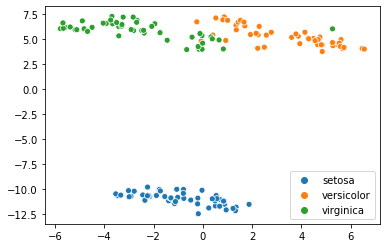

In [5]:
yout = tsne_opt(X)
sns.scatterplot(yout[:,0], yout[:,1], hue = specs)